# M07 Homework
- Name: Sam Remmey
- Net ID: sqr8ap
- URL of this file in GitHub: https://github.com/sqr8ap/DS5001-2025-01-R/blob/m07/lessons/M07_FeaturesAndComponents/M07_HW.ipynb

**Note: I tried several approaches but could not get my plotly plots to render in my html doc, but I've included seaborn plots for reference, and my code for the plotly plots is here, just no output. Hopefully this is sufficient**

In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import norm
from scipy.linalg import eigh
import plotly_express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

In [98]:
import plotly.io as pio
pio.renderers.default = "iframe"

In [3]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [5]:
# Import data

OHCO = ['book_id','chap_id','para_num','sent_num','token_num']

LIB = pd.read_csv(f'{data_home}/novels-LIB.csv').set_index('book_id')
LIB['title'] = LIB.index
LIB.columns = ['genre', 'author', 'title']
TOKEN = pd.read_csv(f'{data_home}/novels-CORPUS.csv').set_index(OHCO)

In [7]:
TOKEN.sample(3)

,,,,,pos,term_str
book_id,chap_id,para_num,sent_num,token_num,,
secretadversary,8,32,2,1,NN,conversation
northangerabbey,13,28,3,34,PRP$,her
dracula,10,70,1,12,NN,gott


In [9]:
LIB.sample(3)

,genre,author,title
book_id,,,
adventures,d,doyle,adventures
marieroget,d,poe,marieroget
signoffour,d,doyle,signoffour


In [11]:
# Extract a VOCAB table and add max_pos as a column

VOCAB = TOKEN.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['max_pos'] = TOKEN[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)

In [13]:
VOCAB.sample(3)

,n,n_chars,p,i,max_pos
term_str,,,,,
downward,18,8,1.199668e-05,16.347005,RB
admittedly,1,10,6.664823e-07,20.516930,RB
tiles,2,5,1.332965e-06,19.516930,NN


In [15]:
# Compute TFIDF and VOCAB['dfidf'] for the CORPUS

def gen_bow(TOKENS, OHCO_LEVEL='CHAPS'):
    '''
    This function takes a tokens table and a choice of bag and returns a BOW representation in the form of a document-term count matrix. 

    Parameters
    TOKENS: tokens table; a dataframe
    OCHO_LEVEL: choice of bag; a string (either 'BOOKS', 'CHAPS', 'PARAS' or 'SENTS'); defaults to 'CHAPS'

    Returns
    DTCM: document-term count matrix
    '''
    OHCO = ['book_id','chap_id','para_num','sent_num','token_num']
    bags = dict(
        SENTS = OHCO[:4],
        PARAS = OHCO[:3],
        CHAPS = OHCO[:2],
        BOOKS = OHCO[:1])
    
    BOW = TOKENS.groupby(bags[OHCO_LEVEL]+['term_str']).term_str.count().to_frame('n')
    DTCM = BOW.n.unstack(fill_value=0)

    return DTCM

def gen_tfidf(DTCM, TF_METHOD='sum'):
    '''
    This function takes a BOW table (DTCM) and type of tf metric and returns the TFIDF/DFIDF values for the BOW. 

    Parameters
    DTCM: BOW table; a dataframe
    TF_METHOD: a string; either 'sum', 'max', 'log', 'raw', 'double_norm' or 'binary'; defaults to 'sum'

    Returns
    TFIDF: a dataframe
    DFIDF: a series
    '''

    tf_norm_k = 0.5
    idf_method = 'standard'
    gradient_cmap = 'YlGnBu'
    tf = {
        'sum': (DTCM.T / DTCM.T.sum()).T,
        'max': (DTCM.T / DTCM.T.max()).T,
        'log': (np.log2(1 + DTCM.T)).T,
        'raw':  DTCM,
        'double_norm': (DTCM.T / DTCM.T.max()).T,
        'binary': DTCM.T.astype('bool').astype('int').T}

    TF = tf[TF_METHOD]

    DF = DTCM.astype('bool').sum() 

    N = DTCM.shape[0]   
    
    IDF = np.log2(N / DF)

    TFIDF = TF * IDF
    DFIDF = DF * IDF
    
    return TFIDF, DFIDF

In [17]:
my_dtcm = gen_bow(TOKEN) # default bag level is chapter
idfs = gen_tfidf(my_dtcm, TF_METHOD = 'max')
TFIDF, DFIDF = idfs[0], idfs[1]

In [19]:
VOCAB['dfidf'] = DFIDF.values

In [21]:
VOCAB.head()

,n,n_chars,p,i,max_pos,dfidf
term_str,,,,,,
a,28533,1,0.019017,5.716586,DT,0.000000
aback,9,5,0.000006,17.347005,NN,46.368028
abaft,2,5,0.000001,19.516930,IN,8.321928
abandon,44,7,0.000029,15.057499,VB,98.408049
abandoned,68,9,0.000045,14.429467,VBN,124.513524


In [23]:
# Create a DOC table from the TFIDF index

TFIDF_reset = TFIDF.reset_index()
DOC = TFIDF_reset.merge(LIB, on='book_id', how='inner')
DOC = DOC.set_index(['book_id', 'chap_id'])
DOC.sample(3)

,,a,aback,abaft,abandon,abandoned,abandoning,abandons,abasement,abashed,abate,...,zuniga,zusammen,à,æt,ætat,ça,émeutes,genre,author_y,title_y
book_id,chap_id,,,,,,,,,,,,,,,,,,,,,
udolpho,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,g,radcliffe,udolpho
oldenglishbaron,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,g,reeve,oldenglishbaron
frankenstein,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,g,shelley,frankenstein


In [25]:
# Create a reduced version of the TFIDF table with only the top 1000 nouns

top_nouns = VOCAB[VOCAB['max_pos'].isin(['NN', 'NNS'])].sort_values(by='dfidf', ascending=False).head(1000)

TFIDF_reduced = TFIDF[top_nouns.index]
TFIDF_reduced.sample(3)

,term_str,yours,reply,order,curiosity,memory,company,feelings,opportunity,book,spirit,...,humanity,rank,contempt,apprehensions,owner,lad,enquiry,bag,investigation,inclination
book_id,chap_id,,,,,,,,,,,,,,,,,,,,,
scarlet,13,0.0,0.0,0.0,0.0,0.000000,0.000000,0.006638,0.013618,0.006809,0.0,...,0.0,0.0,0.0,0.0,0.01485,0.0,0.0,0.0,0.0,0.0
udolpho,21,0.0,0.0,0.0,0.0,0.015182,0.030364,0.000000,0.015574,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
frankenstein,37,0.0,0.0,0.0,0.0,0.000000,0.000000,0.023018,0.000000,0.011806,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


In [27]:
# Write a function that computes PCA from a given dtcm (TFIDF dataframe)

def gen_PCA(X, k, norm_docs=True, center_by_mean=False, center_by_variance=False):
    '''
    This function takes a document term count matrix as input and returns three dataframes: the term-component matrix, the document-component matrix, and the component information table.

    PARAMETERS
    X: the input matrix
    k: number of components to generate
    norm_docs: normalize doc vector lengths; True or False
    center_by_mean: True or False
    center_by_variance: True or False

    RETURNS
    LOADINGS: term-component matrix
    DCM: document-component matrix
    COMPINF: component information table
    '''

    if norm_docs:
        norms = norm(X, 2, axis=1)
        norms[norms == 0] = 1  # Avoid division by zero        
        X = (X.T / norms).T

    X = X.dropna() # remove nulls

    if center_by_variance:
        X = (X - X.mean()) / X.std()
    elif center_by_mean:
        X = X - X.mean()

    # Compute covariance or correlation matrix
    if center_by_mean and center_by_variance:
        COV = np.corrcoef(X.to_numpy(), rowvar=False)  # Correlation matrix
        COV = pd.DataFrame(COV, index=X.columns, columns=X.columns)
    elif center_by_mean and not center_by_variance:
        COV = X.cov()  # Covariance matrix
    elif not center_by_mean and center_by_variance:
        COV = np.corrcoef(X.to_numpy(), rowvar=False)  # Correlation matrix
        COV = pd.DataFrame(COV, index=X.columns, columns=X.columns)
    else:
        COV = X.T.dot(X) / (X.shape[0] - 1)  # Uncentered covariance

    # Decompose the matrix
    eig_vals, eig_vecs = eigh(COV)
    idx = np.argsort(eig_vals)[::-1]  # Sort eigenvalues in descending order
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:, idx]

    # Convert eigen data to dataframes
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'

    # Combine eigenvalues and eigenvectors
    EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

    EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

    # Pick top k components (COMPS)
    COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(k).reset_index(drop=True)
    COMPS.index.name = 'comp_id'
    COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
    COMPS.index.name = 'pc_id'

    # See projected components onto vocabulary (LOADINGS)
    LOADINGS = COMPS[COV.index].T
    LOADINGS.index.name = 'term_str'

    # Component information table?
    top_terms = []
    for i in range(k):
        for j in [0, 1]:
            comp_str = ' '.join(LOADINGS.sort_values(f'PC{i}', ascending=bool(j)).head(k).index.to_list())
            top_terms.append((f"PC{i}", j, comp_str))
    COMP_GLOSS = pd.DataFrame(top_terms).set_index([0,1]).unstack()
    COMP_GLOSS.index.name = 'comp_id'
    COMP_GLOSS.columns = COMP_GLOSS.columns.droplevel(0) 
    COMP_GLOSS = COMP_GLOSS.rename(columns={0:'pos', 1:'neg'})
    COMPINF = COMP_GLOSS

    # Project docs onto components
    DCM = X.dot(LOADINGS)
    DCM = DCM.join(LIB[['genre','author','title']], on='book_id')
    DCM['doc'] = DCM.apply(lambda x: f"{x['title']} {str(x.name[1]).zfill(2)}", 1)

    return LOADINGS, DCM, COMPINF

In [29]:
# Compute PCA from the feature-reduced TFIDF table using your function

loadings, dcm, compinf = gen_PCA(X=TFIDF_reduced, k=10, norm_docs=True, center_by_mean=False, center_by_variance=False)

## Questions

#### 1. Looking at the documents plotted against the first principle component (PC), which genre has the more narrow range, i.e. distance between the minimum and maximum values? This can be seen using a box plot.

In [100]:
px.box(dcm, x='genre', y='PC0')

<Axes: xlabel='genre', ylabel='PC0'>

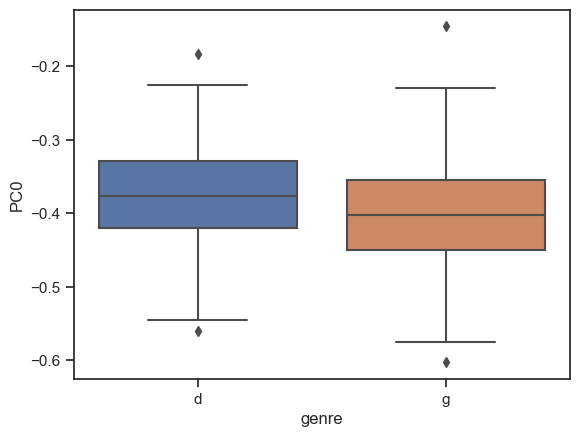

In [33]:
sns.boxplot(dcm, x='genre', y='PC0')

**Genre d** has a more narrow range. 

#### 2. Looking at the documents plotted against the first PC, which author has the highest absolute value, in terms of both mean and range? In other words, which author is farthest from 0? Again, the box plots of each author are useful here.

In [102]:
px.box(dcm, x='author', y='PC0', hover_name='author')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'doyle'),
  Text(1, 0, 'walpole'),
  Text(2, 0, 'dickens'),
  Text(3, 0, 'stoker'),
  Text(4, 0, 'shelley'),
  Text(5, 0, 'poe'),
  Text(6, 0, 'lewis'),
  Text(7, 0, 'collins'),
  Text(8, 0, 'austen'),
  Text(9, 0, 'reeve'),
  Text(10, 0, 'christie'),
  Text(11, 0, 'radcliffe')])

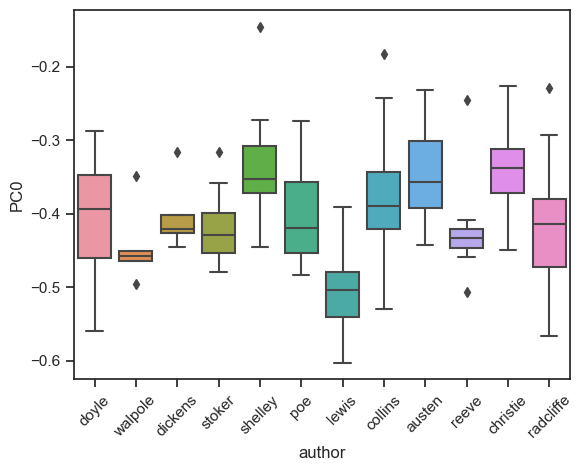

In [37]:
sns.boxplot(dcm, x='author', y='PC0')
plt.xticks(rotation=45)

**Lewis** is farthest from 0. 

#### 3. In the third PC, which author has, by far, the maximum range?

In [104]:
px.box(dcm, x='author', y='PC2') # PC0 is first, PC1 is second, PC2 is third

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'doyle'),
  Text(1, 0, 'walpole'),
  Text(2, 0, 'dickens'),
  Text(3, 0, 'stoker'),
  Text(4, 0, 'shelley'),
  Text(5, 0, 'poe'),
  Text(6, 0, 'lewis'),
  Text(7, 0, 'collins'),
  Text(8, 0, 'austen'),
  Text(9, 0, 'reeve'),
  Text(10, 0, 'christie'),
  Text(11, 0, 'radcliffe')])

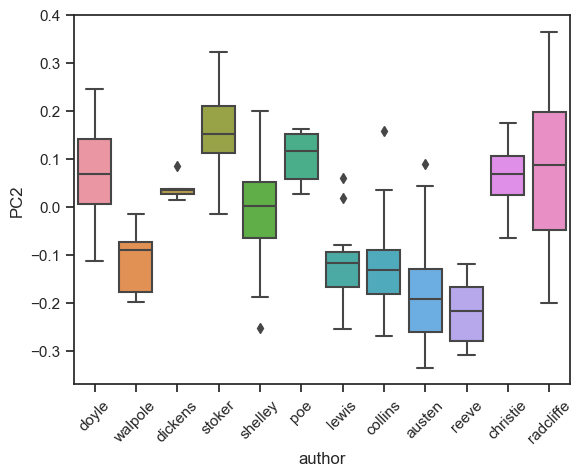

In [41]:
sns.boxplot(dcm, x='author', y='PC2')
plt.xticks(rotation=45)

**Radcliffe** has the maximum range. 

#### 4. Looking at the loadings for the second PC, how would you characterize the opposition, based on the top three words at each pole?

In [108]:
def vis_loadings(a=0, b=1, hover_name='term_str'):
    X = loadings.join(VOCAB)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos', 
                      marginal_x='box', height=800)

In [110]:
vis_loadings()

In [112]:
top_terms_sk= {}

data = []
for i in range(10):
    for j in [0, 1]:
        data.append((f"PC{i}", j, ' '.join(loadings.sort_values(f'PC{i}', ascending=bool(j)).head(10).index.to_list())))

comp_strs = pd.DataFrame(data)
comp_strs.columns =  ['pc', 'pole', 'top_terms']
comp_strs = comp_strs.set_index(['pc', 'pole'])

In [114]:
comp_strs

top_terms
pc  pole                                                   
PC0 0     humanity rank variety mixture apprehensions hi...
    1     castle lady letter aunt chateau father oh cham...
PC1 0     thats youre shes cab girl lawyer police doctor...
    1     chateau castle chamber woods convent apartment...
PC2 0     mountains woods sea rocks whilst road castle m...
    1     brother engagement father son sister letter da...
PC3 0     castle aunt chamber apartment servants corrido...
    1     cottage chateau sea mountains feelings misery ...
PC4 0     chateau thats youre woods shes aunt lawyer gir...
    1     castle blood whilst sleep child monster horror...
PC5 0     thats youre shes guess youve girl oh thoughtfu...
    1     cab chateau dog inquiry police case letter mat...
PC6 0     chateau convent coffee cab crime bed key blood...
    1     mountains castle aunt rocks horses girl sea mo...
PC7 0     aunt whilst sleep aunts mistress patient bag l...
    1     brother castle cab son horse road thats father...
PC8 0     aunt evidence murderer cab murder misery crime...
    1     chateau whilst sleep bed women rooms lady till...
PC9 0     cottage mistress servants lady convent ladys s...
    1     aunt brother acquaintance engagement brothers ...

The top three words at pole 0 for the second principal component are "thats," "youre," and "shes," whereas the top three words at pole 1 for the same component are "chateau," "castle," and "chamber." The words at pole 1 seem to suggest an association with historical/medieval fiction, whereas the words at pole 0 do not suggest an obvious theme/genre, though they are all stop words. 

#### 5. Recompute the principle components with center_by_variance set to True. This will change the words that appear at the extremes of the first PC. Does this change your interpretation in the previous question?

In [116]:
loadings2, dcm2, compinf2 = gen_PCA(X=TFIDF_reduced, k=10, norm_docs=True, center_by_mean=False, center_by_variance=True)

In [118]:
def vis_loadings(a=0, b=1, hover_name='term_str'):
    X = loadings2.join(VOCAB)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos', 
                      marginal_x='box', height=800)

In [129]:
vis_loadings()

In [122]:
top_terms_sk= {}

data = []
for i in range(10):
    for j in [0, 1]:
        data.append((f"PC{i}", j, ' '.join(loadings2.sort_values(f'PC{i}', ascending=bool(j)).head(10).index.to_list())))

comp_strs = pd.DataFrame(data)
comp_strs.columns =  ['pc', 'pole', 'top_terms']
comp_strs = comp_strs.set_index(['pc', 'pole'])

In [124]:
comp_strs

top_terms
pc  pole                                                   
PC0 0     countenance length melancholy scene sufferings...
    1     matter anything course case yes sort thats wor...
PC1 0     light sound darkness sun teeth clouds wall fea...
    1     family honour conduct opinion engagement fortu...
PC2 0     woods twilight landscape shade gay chateau gra...
    1     bosom cause power blood shame soul fear aid de...
PC3 0     feelings creatures sensations monster misery t...
    1     person chamber stair lamp case circumstances s...
PC4 0     thoughtfully thats youre somehow youve oh sigh...
    1     country companion companions nature progress s...
PC5 0     crime idea anyone existence murder thoughtfull...
    1     rest till sleep ladies things women people pat...
PC6 0     experience misery position interval interview ...
    1     acquaintance friendship minutes lamp brother h...
PC7 0     home habit indeed study delicacy importance na...
    1     servants castle hither justice rage lady apart...
PC8 0     affairs hereafter son mans master title estate...
    1     vain feelings anybody creature ladies horror l...
PC9 0     expectation castle apartment brother alarm ind...
    1     bosom shade mother air virtue sentiments lands...

Yes, setting center_by_variance to True changes my interpretation. Now, the words at pole 0 are "light," "sound," and "darkness," and the words at pole 1 are "family," "honour," and "conduct." These words suggest a distinction between environmental, sensory terms and social, interpersonal terms. The terms at pole 0 seem more likely to be from gothic texts, whereas the terms at pole 1 seem more likely to be from detective texts. 